# 商务案例: 在线用户评论分析
# 1. 数据集介绍
**Yelp**数据集整理自官方公开 (https://www.yelp.com/dataset) 的商户、点评和用户数据。本实验使用所有位于多伦多的餐馆截至2017年7月的评论数据(review_res.txt)开展文本挖掘，数据字段及具体含义如下：
- user_id: 用户ID
- business_id: 商户ID
- date: 用户评论日期
- text: 用户评论内容
- stars: 用户评分星级，1星到5星

# 2. 数据预处理
调用1-preprocessing.py对review_res.txt进行预处理，对评论内容进行词条化、规范化和噪音去除这一系列操作，得到data_preprocessed.csv。此外，评分4星及以上的评论被标记为正向评论，而评分3星及以下的评论则被标记为负向评论。
# 3. 实验准备

In [3]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np
import warnings
warnings.simplefilter("ignore")

## 3.1. 载入预处理后的数据

In [4]:
reviews = pd.read_csv("./data_preprocessed_10%.csv")
print ("# of reviews: ", reviews.shape[0])
reviews_senti_count = reviews.groupby("sentiment").count()
print(reviews_senti_count)
reviews.head()

# of reviews:  27687
           review
sentiment        
0           10797
1           16890


,review,sentiment
0,leave table feel ambivalent meh others would p...,0
1,book private room small wedding reception rece...,1
2,love place definitely little pricey special oc...,1
3,first time come table little year ago take gra...,1
4,wish could share avitania groupon enthusiasm f...,0


## 3.2. 划分训练集与测试集

In [5]:
X = []
for index, row in reviews.iterrows():
    review = row['review']
    X.append(review)
y = reviews["sentiment"]

from sklearn.model_selection import train_test_split
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 628)
print(len(X_train), len(X_test))

22149 5538


# 4. 实验设计
## 4.1. 评论情感分析 - 向量空间模型
### 4.1.1. 词频向量 + 逻辑回归

In [6]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
tf_vec = CountVectorizer()
X_train_tf = tf_vec.fit_transform(X_train)
X_test_tf = tf_vec.transform(X_test)
print(X_train_tf.shape, X_test_tf.shape)

(22149, 35639) (5538, 35639)


In [8]:
from sklearn.linear_model import LogisticRegression
# Fitting a logistic regression model with default parameters
logreg = LogisticRegression()
logreg.fit(X_train_tf, y_train)
# Prediction & Evaluation
y_hat_test = logreg.predict(X_test_tf)
print("Precision: {:.3f}".format(precision_score(y_test, y_hat_test)), "Recall: {:.3f}".format(recall_score(y_test, y_hat_test)))
print("F1 score: {:.3f}".format(f1_score(y_test, y_hat_test)))
y_hat_test = logreg.predict_proba(X_test_tf)
print("AUC score: {:.3f}".format(roc_auc_score(y_test, y_hat_test[:,1])))

Precision: 0.846 Recall: 0.882
F1 score: 0.864
AUC score: 0.889


### 4.1.2. TF-IDF向量 + 逻辑回归

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer()
X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)
print(X_train_tfidf.shape, X_test_tfidf.shape)

(22149, 35639) (5538, 35639)


In [10]:
# Fitting a logistic regression model with default parameters
logreg = LogisticRegression()
logreg.fit(X_train_tfidf, y_train)
# Prediction & Evaluation
y_hat_test = logreg.predict(X_test_tfidf)
print("Precision: {:.3f}".format(precision_score(y_test, y_hat_test)), "Recall: {:.3f}".format(recall_score(y_test, y_hat_test)))
print("F1 score: {:.3f}".format(f1_score(y_test, y_hat_test)))
y_hat_test = logreg.predict_proba(X_test_tfidf)
print("AUC score: {:.3f}".format(roc_auc_score(y_test, y_hat_test[:,1])))

Precision: 0.847 Recall: 0.906
F1 score: 0.876
AUC score: 0.913


## 4.2. 评论主题提取 - 主题模型

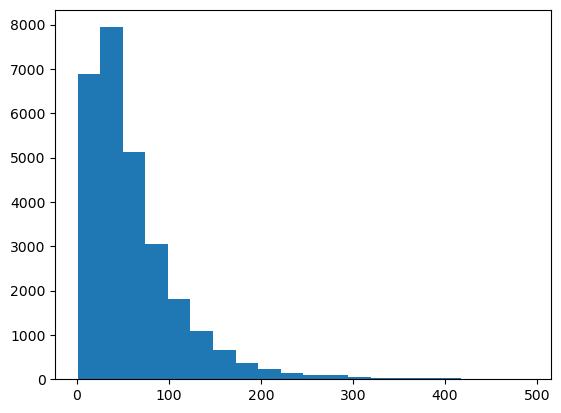

In [11]:
doc_len = []
for review in X:
    doc_len.append(len(review.split(' ')))
plt.hist(doc_len, bins = 20)
plt.show()

### 应用Latent Dirichlet Allocation模型

In [12]:
from gensim import corpora, models
X_train_s = [text.split(' ') for text in X_train]
X_test_s = [text.split(' ') for text in X_test]

dictionary = corpora.Dictionary(X_train_s)
corpus_train = [dictionary.doc2bow(text) for text in X_train_s]
corpus_test = [dictionary.doc2bow(text) for text in X_test_s]

topic_n = 50
lda = models.LdaModel(corpus = corpus_train, id2word = dictionary, num_topics = topic_n, passes = 10, alpha = 0.1, eta = 0.01)
topic_list = lda.print_topics(10)
for topic in topic_list:
    print(topic)

(18, '0.108*"beer" + 0.070*"drink" + 0.049*"selection" + 0.048*"bar" + 0.038*"good" + 0.032*"great" + 0.023*"place" + 0.020*"food" + 0.019*"pub" + 0.019*"tap"')
(47, '0.089*"great" + 0.070*"food" + 0.054*"service" + 0.043*"place" + 0.036*"good" + 0.036*"friendly" + 0.032*"delicious" + 0.023*"nice" + 0.023*"really" + 0.021*"love"')
(26, '0.035*"get" + 0.028*"like" + 0.018*"place" + 0.017*"know" + 0.017*"even" + 0.017*"eat" + 0.016*"one" + 0.014*"food" + 0.014*"time" + 0.014*"bad"')
(4, '0.106*"oyster" + 0.051*"event" + 0.041*"classy" + 0.036*"top" + 0.031*"subway" + 0.030*"yorkville" + 0.027*"expectation" + 0.025*"notch" + 0.023*"katsu" + 0.019*"dozen"')
(3, '0.082*"option" + 0.047*"vegetarian" + 0.036*"veggie" + 0.031*"vegan" + 0.029*"menu" + 0.027*"wrap" + 0.021*"meat" + 0.020*"make" + 0.020*"healthy" + 0.019*"lot"')
(27, '0.155*"lamb" + 0.073*"kid" + 0.029*"flight" + 0.027*"hubby" + 0.025*"son" + 0.023*"totally" + 0.022*"stew" + 0.020*"mozzarella" + 0.019*"prosciutto" + 0.018*"guu"')

### LDA主题可视化

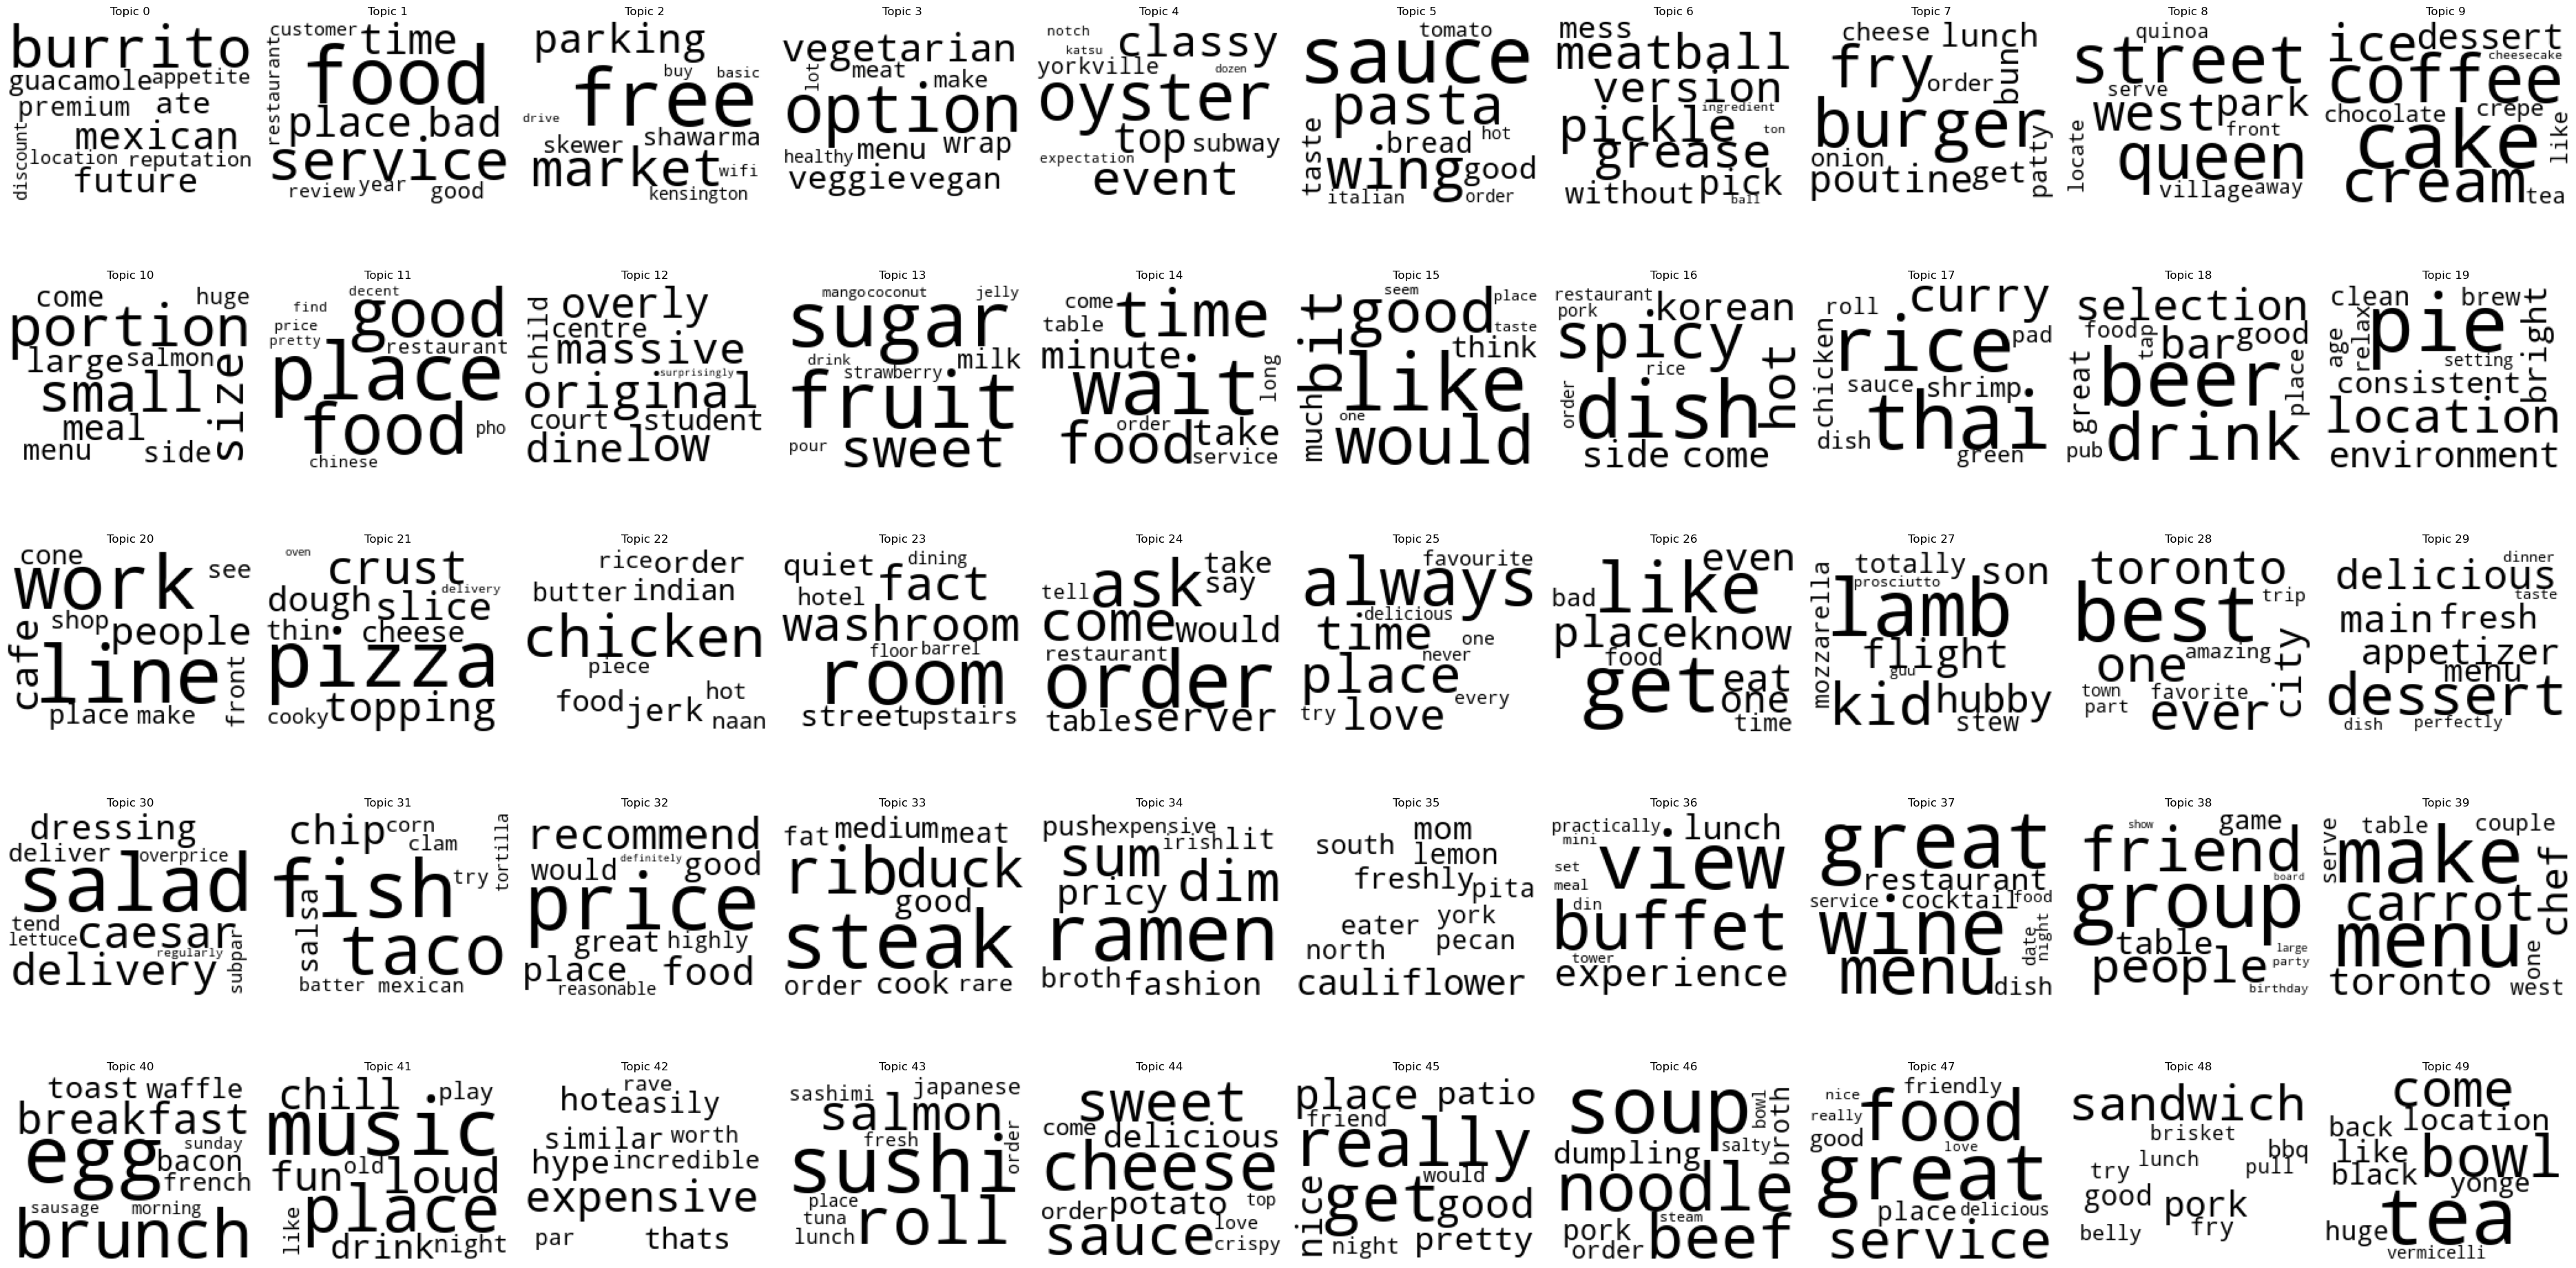

In [13]:
from wordcloud import WordCloud
cloud = WordCloud(background_color = 'white', width = 200, height = 150, max_words = 20, color_func = lambda *args, **kwargs: 'black')
topics = lda.show_topics(formatted = False, num_topics = 50)

fig, axes = plt.subplots(5, 10, figsize = (37.5, 20), sharex = True, sharey = True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size = 64)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict = dict(size=12))
    plt.gca().axis('off')


plt.subplots_adjust(wspace = 0, hspace = 0)
plt.margins(x = 0, y = 0)
plt.tight_layout()
plt.show()

## 4.3. 评论情感分析 - 词向量模型
### 4.3.1. Word2vec(预训练) + 逻辑回归

In [14]:
# load pre-trained English word vectors
# https://fasttext.cc/docs/en/english-vectors.html

voca = {}
for review in X:
    words = review.split(' ')
    for word in words:
        voca[word] = 1
print("# of words", len(voca.keys()))

data = {}
file = open("E:/本科/数据挖掘与商务分析/6/wiki-news-300d-1M.vec", "r")
while 1:
    line = file.readline()
    if not line:
        break
    else:
        segs = line.split(" ")
        if segs[0] in voca:
            data[segs[0]] = np.array([float(seg) for seg in segs[1:]])
file.close()

def text2vec(text):
    vals = np.zeros(300)
    n = 0
    if len(text) == 0:
        return vals
    else:
        words = text.split(' ')
        for word in words:
            if word in data:
                vals += data[word]
                n += 1
        if n == 0:
            return vals
        else:
            return vals/n

X_train_word2vec = np.array([text2vec(text) for text in X_train])
X_test_word2vec = np.array([text2vec(text) for text in X_test])
print(X_train_word2vec.shape, X_test_word2vec.shape)

# of words 39990
(22149, 300) (5538, 300)


In [15]:
# Fitting a logistic regression model with default parameters
logreg = LogisticRegression()
logreg.fit(X_train_word2vec, y_train)
# Prediction & Evaluation
y_hat_test = logreg.predict(X_test_word2vec)
print("Precision: {:.3f}".format(precision_score(y_test, y_hat_test)), "Recall: {:.3f}".format(recall_score(y_test, y_hat_test)))
print("F1 score: {:.3f}".format(f1_score(y_test, y_hat_test)))
y_hat_test = logreg.predict_proba(X_test_word2vec)
print("AUC score: {:.3f}".format(roc_auc_score(y_test, y_hat_test[:,1])))

Precision: 0.821 Recall: 0.879
F1 score: 0.849
AUC score: 0.877


### 4.3.2. SBERT + 逻辑回归

In [16]:
# Use the raw data set
reviews = pd.read_csv("./review_res_10%.txt", sep = "\t")
reviews.head()

,review_id,user_id,business_id,stars,date,useful,funny,cool,text
0,Z5l99h18E3_g1GLcDSsWqA,djpMXOA1ic5wv3FPtubHNw,mr4FiPaXTWlJ3qGzp4-7Yg,3,2009-07-21,3,0,0,I left Table 17 feeling very ambivalent. Meh a...
1,zxVqUWJbDRhjwLKTsCt5eg,MFNZ5_mQIPOsGO-PBmf26Q,mr4FiPaXTWlJ3qGzp4-7Yg,5,2014-07-29,0,0,1,I booked the private room for a small wedding ...
2,WcgoxemFDJbv33uc4FLxew,AhoxHm569hH_PRkoegDwcA,mr4FiPaXTWlJ3qGzp4-7Yg,4,2010-12-14,4,1,3,I love this place. It's definitely a little p...
3,elb_JjGey_SGKUyo91c8hA,DuoBTfKNM67965BcrlYBYg,mr4FiPaXTWlJ3qGzp4-7Yg,4,2013-11-15,1,1,1,The first time I came to Table 17 was a little...
4,8pDkQMl1UYO7goTuKHDaNw,2VKVhy1SwaixHCeiWglLUQ,mr4FiPaXTWlJ3qGzp4-7Yg,2,2011-02-04,3,3,0,I wish I could share Avitania B.'s Groupon ent...


In [17]:
reviews["sentiment"] = (reviews["stars"] >= 4) * 1
X = []
for index, row in reviews.iterrows():
    review = row['text']
    X.append(review)
y = reviews["sentiment"]

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 628)
print(len(X_train), len(X_test))

22151 5538


In [18]:
from sentence_transformers import SentenceTransformer
# https://sbert.net/docs/installation.html
# Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

In [19]:
# Calculate embeddings
X_train_sbert = model.encode(X_train)
X_test_sbert = model.encode(X_test)
print(X_train_sbert.shape, X_test_sbert.shape)

(22151, 384) (5538, 384)


In [20]:
# Fitting a logistic regression model with default parameters
logreg = LogisticRegression()
logreg.fit(X_train_sbert, y_train)
# Prediction & Evaluation
y_hat_test = logreg.predict(X_test_sbert)
print("Precision: {:.3f}".format(precision_score(y_test, y_hat_test)), "Recall: {:.3f}".format(recall_score(y_test, y_hat_test)))
print("F1 score: {:.3f}".format(f1_score(y_test, y_hat_test)))
y_hat_test = logreg.predict_proba(X_test_sbert)
print("AUC score: {:.3f}".format(roc_auc_score(y_test, y_hat_test[:,1])))

Precision: 0.841 Recall: 0.885
F1 score: 0.862
AUC score: 0.894
